In [7]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn

### Relaxation Methods
Relaxation methods, as represented by the Jacobi and Gauss-Seidel iterations, begin with an initial guess at a solution.  They then proceed to improve the current approximation by a succession of simple updating steps or iterations.  The sequence of approximations converges to the exact solution of the linear system (ideally). 

These relaxation methods suffer from some disabling limitations, and multigrid methods are primarily motivated as attempts to correct these limitations.  

Multigrid/relaxation methods have more generality and a wider range of application than the specialized direct methods. 


1. $\Omega^h = $: a grid with h grid points in the domain [0,1]

2.  $\mathbf{u}^h$: exact solution of the system $A \mathbf{u}^h = \mathbf{f}$, associated for the particular grid $\Omega^h$

3.  $\mathbf{v}^h$: approximation to the exact solution, which is generated by some iterative method, associated for the particular grid $\Omega^h$

4.  $\mathbf{e}^h = \mathbf{u}^h - \mathbf{v}^h$

The error is also some vector and we will be using the following norms to look at the error: 

$$
| \mathbf{e} |_{\infty} = \max_{1 \leq j \leq N} | e_j| \text{ and } | \mathbf{e} |_2 = \left(\sum_{j=1}^N e_j^2 \right)^{1/2}
$$

Knowing the error is a bit unaccesible because it requires us knowing the exact solution.  This motivates us to look a the $\textit{residual}$, $\mathbf{r} = f - A\mathbf{v}$, which is the amount by which the approximation $\mathbf{v}$ fails to satisfy the original problem $A \mathbf{u} = f$

With these definitions, we have the following residual equation $ A \mathbf{e} = \mathbf{r}$

Most basic relaxation schemes suffer in the presence of smooth components of the error.  Let us assume then that a particular relaxation scheme has been applied until only smooth error components remain.  We want to know what these smooth components look like on a coarse grid.  Let us examine what happens.  

#### Relaxation Methods and Initial Guess

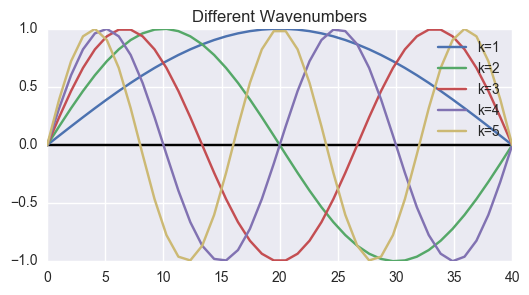

In [42]:
wavenumbers = [j for j in range(1,6)]
N = 40
x = np.linspace(0, 40, N)
fig = plt.figure(figsize=(6,3))
axes = fig.add_subplot(1,1,1)
#axes.plot(np.zeros(100), np.linspace(-1,1,100), 'k')
axes.plot(np.linspace(0, 40, 100), np.zeros(100), 'k') #x axis
for idx, k in enumerate(wavenumbers):
    axes.plot(x, np.sin(x * k * np.pi / N), label='k=%d' % k)

axes.set_title("Different Wavenumbers")
axes.legend(loc=1)
plt.show()

Current approximation, or the initial guess on the first iteration, is denoted $\mathbf{v}^{(0)}$, and the new updated approximation is $\mathbf{v}^{(1)}$.  

The jacobi method for the problem $u''(x) = f(x)$, is:

$$
    U_i^{(k+1)} = \frac{1}{2} (U_{i+1}^{(k)} + U_{i-1}^{(k)}) - f(x_i) \frac{\Delta x^2}{2}.
$$

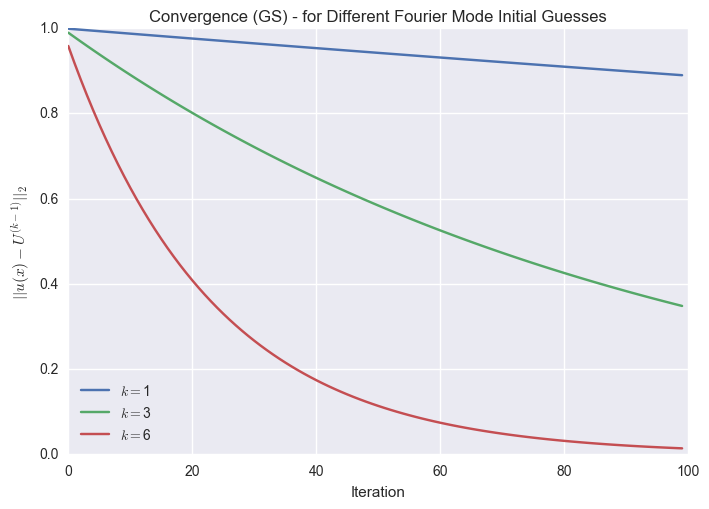

In [108]:
# Jacobi Method - most simple 
# u''(x) = f(x) = 0


# interval
a = 0.0 
b = 1.0
# boundary conditions 
u_a = 0.0  # u(0) = 0.0
u_b = 0.0  # u(1) = 0.0

f = lambda x: np.exp(x)
#u_true = lambda x: (4.0 - np.exp(1.0)) * x - 1.0 + np.exp(x)
u_true = lambda x: 0
def initial_guess(length, k, N):
    guess = np.zeros(length)
    for j in range(length):
        guess[j] = np.sin((j)*k*np.pi / (N) )
    return guess
    
# Discretization
m = 64                           # 100 interior points
x_bc = np.linspace(a, b, m + 2)  # 102 total points, include boundary
x = x_bc[1:-1]                      # interior points (size m)
delta_x = (b - a) / (m + 1)      

# Expected iterations needed
iterations_J = int(2.0 * np.log(delta_x) / np.log(1.0 - 0.5 * np.pi**2 * delta_x**2))
iterations_J = 100
# Solve system
# Initial guess for iterations

wavenumbers = [k for k in [1, 3, 6] ]
fig = plt.figure()
#fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1,1,1)


#axes.plot(range(iterations_J), np.ones(iterations_J) * delta_x**2, 'r--')
axes.set_xlabel("Iteration")
axes.set_ylabel("$||u(x) - U^{(k-1)}||_2$")

for idx, wavenumber in enumerate(wavenumbers):
    U_new = initial_guess(length=m+2, k=wavenumber, N=m+1)
    U_new[0] = u_a
    U_new[-1] = u_b
    convergence_J = np.zeros(iterations_J)
    step_size_J = np.zeros(iterations_J)
    for k in xrange(iterations_J):
        U = U_new.copy()
        for i in xrange(1, m + 1):
            #U_new[i] = 0.5 * (U[i+1] + U[i-1]) - f(x_bc[i]) * delta_x**2 / 2.0
            U_new[i] = 0.5 * (U[i+1] + U[i-1])

        step_size_J[k] = np.linalg.norm(U - U_new, ord=2)
        convergence_J[k] = np.linalg.norm(u_true(x_bc) - U_new, ord=np.infty)
    
    # plotting 
    axes.plot(range(iterations_J), convergence_J, label=r"$k=$%d" % wavenumber)
axes.legend(loc=3) 
axes.set_title("Convergence (GS) - for Different Fourier Mode Initial Guesses")
plt.show()

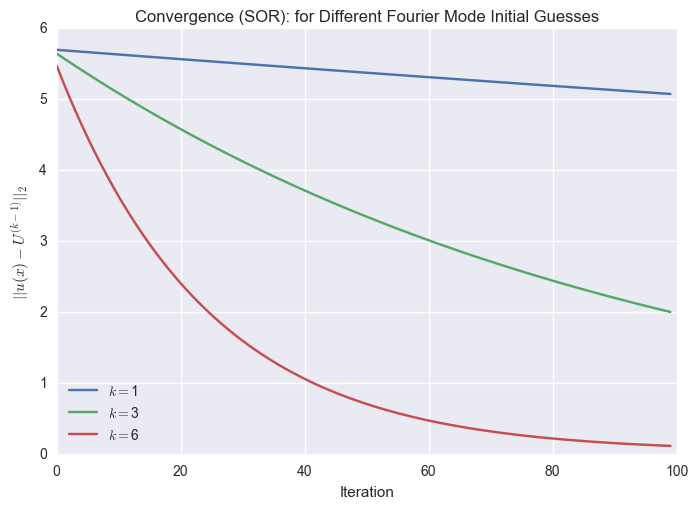

In [107]:
# Problem setup
a = 0.0
b = 1.0
u_a = 0.0
u_b = 0.0
f = lambda x: np.exp(x)
#u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)
u_true = lambda x: 0
def initial_guess(length, k, N):
    guess = np.zeros(length)
    for j in range(length):
        guess[j] = np.sin((j)*k*np.pi / (N) )
    return guess

# Discretization
m = 64
x_bc = np.linspace(a, b, m + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (m + 1)

# SOR parameter
#omega = 2.0 / (1.0 + np.sin(np.pi * delta_x))
omega = 2.0/3.0

# Expected iterations needed
#iterations_SOR = int(2.0 * np.log(delta_x) / np.log(1.0 - 2.0 * np.pi * delta_x)) * 2
iterations_SOR = 100

# Solve system
# Initial guess for iterations
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.set_title("Convergence (SOR): Different Fourier Mode Initial Guesses")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||u(x) - U^{(k-1)}||_2$")
for idx, wavenumber in enumerate(wavenumbers):
    U = initial_guess(length=m+2, k=wavenumber, N=m+1)
    U[0] = u_a
    U[-1] = u_b
    step_size_SOR = np.zeros(iterations_SOR)
    convergence_SOR = np.zeros(iterations_SOR)
    for k in xrange(iterations_SOR):
        U_old = U.copy()
        for i in xrange(1, m + 1):
            U_gs = 0.5 * (U[i-1] + U[i+1])
            U[i] += omega * (U_gs - U[i])

        convergence_SOR[k] = np.linalg.norm(u_true(x_bc) - U, ord=2)
        
    # Plot result
    axes.plot(range(iterations_SOR), convergence_SOR, label=r"$k=$%d" % wavenumber)
axes.legend(loc=3)
plt.show()

The linear interpolation operator $I^h_{2h}$, takes coarse grid vectors and produces fine grid vectors according to the rule $I_{2h}^h \mathbf{v}^{2h} = \mathbf{v}^h$, where 

$$
v_{2j}^h = v_j^{2h} ~ \text{ and } ~ v_{2j+1}^h = \frac 1 2 \left(v_j^{2h} + v_{j+1}^{2h}\right)  ~~~ \text{ for } 0 \leq j \leq \frac N 2 -1 
$$

What this says is, that at even-numbered fine grid points, the values of the vectr are transferred directly from $\Omega_h$ (coarse) to $\Omega_{2h}$ (fine).  At odd-numbered fine grid points, the value of $\mathbf{v}^h$ (fine) is the average of the adjacent coarse grid values. 

The linear operator $I_{2h}^h: \mathbb{R}^{N/2 -1} \rightarrow \mathbb{R}^{N-1}$.  The matrix has full rank and trivial Null space.  For the case $N=8$, we have:
$$
I_{2h}^h \mathbf{v}^{2h} = \begin{bmatrix} 1 \\ 1 \\ \frac 1 2 & \frac 1 2 \\ & 1 \\ & \frac 1 2 & \frac 1 2 \\ & & 1 \\ & & 1 \end{bmatrix} \begin{bmatrix} v_1^{2h} \\ v_2^{2h} \\ v_3^{2h} \end{bmatrix} = \begin{bmatrix}v_1^h \\ v_2^h \\ v_3^h \\ v_4^h \\v_5^h \\ v_6^h \\ v_7^h \end{bmatrix} = \mathbf{v}^h
$$

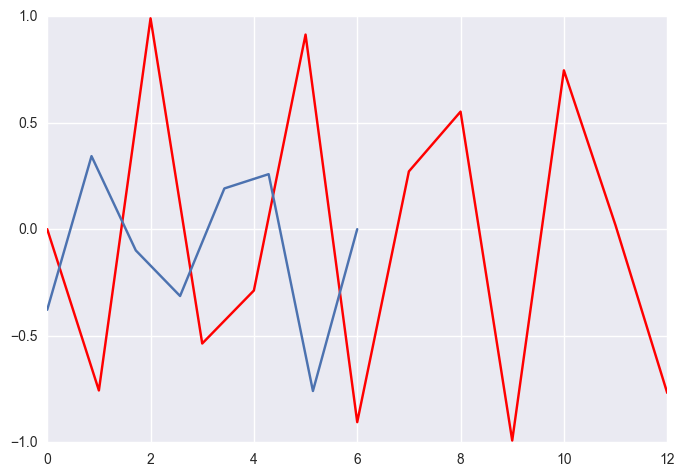

In [16]:

def getInterpolation_T(m, level, max_level=4):
	'''
	Parameters/Arguments
	m: the number of discretizations within the interval [a,b]
    including the boundary points
	level: grid level

	Output/Return
	Returns the matrix interpolating matrix T that interpolates 
	points from a grid level i to a grid level i+1 

	fine to coarse discretization

	'''
	if level >= max_level:
		print("grid level must be less than the maximum grid level")
		return
	else:
		T = np.zeros((m, m/2 + 2))
		 #iterate row by row
		j = k = 0
		for i in range(T.shape[0]):
			if (i % 2) == 0:
				T[i, j] = 1
				j += 1
			else:
				T[i, k] = .5
				T[i, k+1] = .5
				k+=1
		return T

x_level_1 = np.linspace(0,1,13)*12  # 11 interior points + 2 boundary pts = 13 total
x_level_2 = np.linspace(0,1, 7)*6  # 5 interior points + 2 boundary points = 7 total
plt.plot(x_level_1, np.sin(4.0 * x_level_1), 'r')

#plt.plot(x_level_2, np.dot(np.sin(4.0 * x_level_1), getInterpolation_T(m=13, level=1) ) )
T = getInterpolation_T(m=13, level=1)

plt.plot(np.linspace(0,1,8)*6, np.dot(np.sin(4.0 * x_level_1), T ))
plt.show()